# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [1]:
import napari
from macrohet import dataio, tile
import btrack

In [2]:
btrack.__version__

'0.4.6'

In [3]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = dataio.read_harmony_metadata(metadata_fn)

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


In [4]:
metadata_path = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)


Reading metadata XML file...
Extracting metadata complete!


In [5]:
row = 3
column = 5

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [6]:
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane='sum_proj',
#                              set_channel=1,
#                              set_time = 66,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()

In [7]:
%%time
images = images.compute().compute()

CPU times: user 3h 42min 18s, sys: 7min 43s, total: 3h 50min 1s
Wall time: 8min 38s


# Load tracks

In [8]:
with btrack.dataio.HDF5FileHandler(f"/mnt/DATA/macrohet/labels/full_localisation/upscale_{row,column}.h5", 'r') as hdf:
    tracks = hdf.tracks
    segmentation = hdf.segmentation
    objects = hdf.objects
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)

[INFO][2023/04/14 02:37:24 PM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/upscale_(3, 5).h5...
[INFO][2023/04/14 02:37:24 PM] Loading tracks/obj_type_1
[INFO][2023/04/14 02:37:24 PM] Loading objects/obj_type_1 (31313, 5) (31313 filtered: None)
[INFO][2023/04/14 02:37:34 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/04/14 02:37:34 PM] Loading objects/obj_type_1 (31313, 5) (31313 filtered: None)
[INFO][2023/04/14 02:37:34 PM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/upscale_(3, 5).h5


# Launch napari image viewer

In [25]:
viewer = napari.Viewer()

viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green",  "magenta"],
                 contrast_limits=[[100, 6000], [100, 2000]], visible = False
                 )
viewer.add_labels(segmentation, 
                  #scale=(10, 1, 1,), 
#                   color={1:'yellow'}
                 )
viewer.add_tracks(napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
#                     name="Tracks [5,4]", 
                    blending="translucent",
                    visible=True,
#                     scale = (100,1,1)
                )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'napari_tracks' at 0x7f9ddf920be0>

# Fixing duplicate localisation bug

When tracking on upscaled images, there appears to be multiple localisations for each cell.

In [26]:
objects[0].t

0

In [27]:
objects[0]

,ID,x,y,z,t,dummy,states,label,prob,area,major_axis_length,mean_intensity-0,mean_intensity-1,minor_axis_length,orientation
0,0,361.416382,82.760368,0.0,0,False,0,5,0.0,21045.0,214.413834,1194.513794,344.165924,129.839615,0.75574


In [28]:
# isolate objects in first frame
objs_t0 = [o for o in objects if o.t == 0]

In [29]:
# isolate objects in second frame
objs_t1 = [o for o in objects if o.t == 1]

In [30]:
len(objs_t0), len(objs_t1)

(482, 491)

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot:>

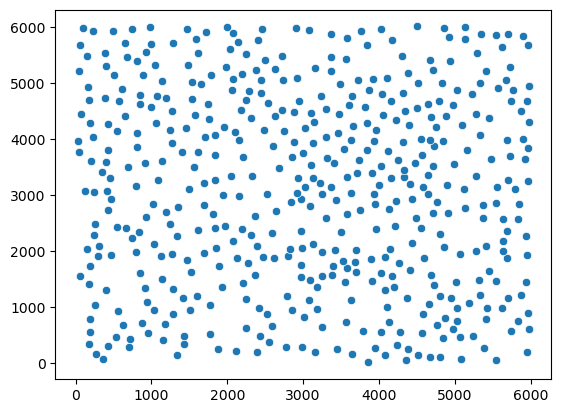

In [32]:
x_coords = [o.x for o in objs_t0]
y_coords = [o.y for o in objs_t0]
sns.scatterplot(x = x_coords, y = y_coords)

<AxesSubplot:>

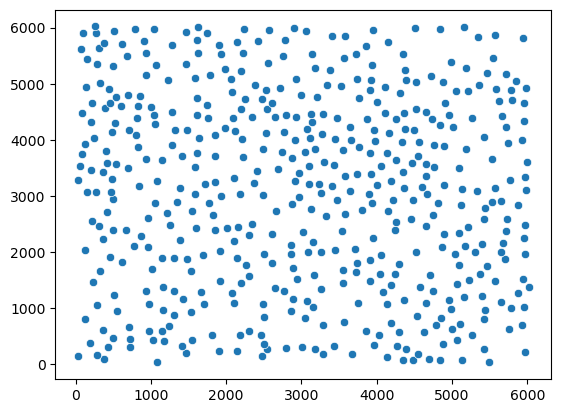

In [33]:
x_coords = [o.x for o in objs_t1]
y_coords = [o.y for o in objs_t1]
sns.scatterplot(x = x_coords, y = y_coords)

In [34]:
xy_coords = [[y, x] for x, y in zip(x_coords, y_coords)]

In [35]:
viewer.add_points(xy_coords, ndim=2)

<Points layer 'Points' at 0x7f9de3650310>

happens at the second frame (t =1), does the tracker think the cells are dividing?

In [36]:
track_352 = [track for track in tracks if track.ID == 352][0]

In [37]:
track_352

,ID,t,x,y,z,parent,root,state,generation,dummy,minor_axis_length,major_axis_length,mean_intensity-0,mean_intensity-1,area,orientation
0,352,0,1246.543945,2488.895020,0.000000,352,352,5,0,False,205.807312,530.678467,1331.943604,375.271912,82943.0,1.342122
1,352,0,545.977722,2432.095947,0.000000,352,352,5,0,False,105.054680,151.087875,3039.468018,371.126495,12403.0,1.044592
2,352,0,257.165314,2485.596680,0.000000,352,352,5,0,False,168.419556,343.183380,2464.495605,381.730988,40935.0,-1.251694
3,352,3,1829.978882,526.998413,-0.989887,352,352,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
4,352,0,5833.124512,2569.903076,0.000000,352,352,5,0,False,166.894241,267.503113,1702.591187,527.751404,33226.0,0.352546
5,352,5,1793.176636,555.813904,9.203656,352,352,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
6,352,0,5636.162598,2573.446045,0.000000,352,352,5,0,False,228.625671,410.572693,2152.761719,378.951324,65616.0,0.997570
7,352,7,1817.808472,541.045959,1.416201,352,352,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
8,352,0,933.739807,2609.950928,0.000000,352,352,5,0,False,153.932327,323.986023,2121.225586,374.938660,37422.0,-0.301992
9,352,0,5130.161621,2765.235107,0.000000,352,352,5,0,False,237.120209,549.959961,2459.670898,430.740387,94283.0,-0.561356


In [38]:
track_463 = [track for track in tracks if track.ID == 463][0]

In [39]:
track_463

,ID,t,x,y,z,parent,root,state,generation,dummy,minor_axis_length,major_axis_length,mean_intensity-0,mean_intensity-1,area,orientation
0,463,1,937.581421,5157.688965,0.000000,463,463,5,0,False,173.584747,366.222046,1671.662476,393.750641,48065.0,1.042029
1,463,1,247.657028,2289.098145,0.000000,463,463,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
2,463,2,247.657028,2289.098145,0.000000,463,463,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
3,463,1,1981.854980,5271.165039,0.000000,463,463,5,0,False,266.721039,381.243866,2246.653809,354.846161,76747.0,0.160620
4,463,4,376.375641,2251.976807,0.045263,463,463,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
5,463,1,5182.459961,5276.767578,0.000000,463,463,5,0,False,218.019180,433.842621,2224.533447,378.238617,68762.0,0.020345
6,463,6,425.911743,2227.082031,-1.325690,463,463,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
7,463,7,468.839905,2209.047363,-2.651379,463,463,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
8,463,8,511.768066,2191.012695,-3.977068,463,463,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
9,463,9,554.696228,2172.978027,-5.302758,463,463,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
def track_and_show(objects, masks, config_fn, search_radius = 20, method = ["MOTION", "VISUAL"], optimize = True):
    
    # initialise a tracker session using a context manager
    with btrack.BayesianTracker() as tracker:
        # configure the tracker using a config file
        tracker.configure(config_fn)
        # set max search radius
        tracker.max_search_radius = search_radius
        # define tracking method
        tracker.tracking_updates = method
        # redefine features so that both channels are included in track measurements
        tracker.features = list(objects[0].properties.keys())
        # append the objects to be tracked
        tracker.append(objects)
        # set the tracking volume
        tracker.volume=((0, 6048), (0, 6048))
        # track them (in interactive mode)
        tracker.track(step_size=25)
        # generate hypotheses and run the global optimizer
        if optimize:
            tracker.optimize()
        # store the tracks
        tracks = tracker.tracks
    
    napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)
    
    viewer.add_tracks(napari_tracks, 
                      blending="translucent",
                      visible=True,)
    
    return tracks

<AxesSubplot:ylabel='Count'>

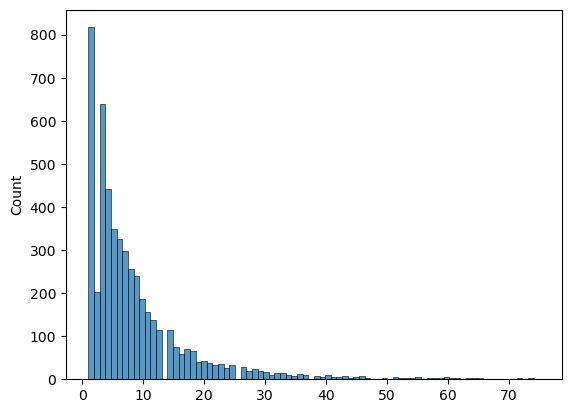

In [41]:
sns.histplot([len(track) for track in tracks])

In [43]:
tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,minor_axis_length,major_axis_length,mean_intensity-0,mean_intensity-1,area,orientation
0,317,0,361.416382,82.760368,0.0,317,317,5,0,False,129.839615,214.413834,1194.513794,344.165924,21045.0,0.755740
1,317,1,5379.537598,277.809387,0.0,317,317,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
2,317,2,5379.537598,277.809387,0.0,317,317,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
3,317,0,1334.278198,153.467621,0.0,317,317,5,0,False,149.110214,827.197693,1148.944336,361.852295,84672.0,1.265559


In [61]:
%%time
images = images.compute().compute()

CPU times: user 3h 44min 2s, sys: 15min 23s, total: 3h 59min 25s
Wall time: 12min 14s


In [62]:
viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green",  "magenta"],
                 contrast_limits=[[100, 6000], [100, 2000]], visible = False
                 )

[<Image layer 'macrophage [1]' at 0x7f62ddc28310>,
 <Image layer 'mtb [1]' at 0x7f644c5b6c10>]

In [83]:
list(objects[0].properties.keys())

['area',
 'major_axis_length',
 'mean_intensity-0',
 'mean_intensity-1',
 'minor_axis_length',
 'orientation']

In [102]:
tracks = track_and_show(objects, 
               segmentation, 
#                '/home/dayn/analysis/btrack/models/simplecase_cell_config.json', 
               '/home/dayn/analysis/btrack/models/particle_config.json', 
               200, 
               ["MOTION",
                "VISUAL"
               ],
               True
              )

[INFO][2023/04/14 11:32:06 am] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
14-Apr-23 11:32:06 - btrack.libwrapper - INFO     - Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[WARNING][2023/04/14 11:32:06 am] btrack (v0.5.0) shared library mismatch.
14-Apr-23 11:32:06 - btrack.core - WARNING  - btrack (v0.5.0) shared library mismatch.
[INFO][2023/04/14 11:32:06 am] Starting BayesianTracker session
14-Apr-23 11:32:06 - btrack.core - INFO     - Starting BayesianTracker session
[INFO][2023/04/14 11:32:06 am] Loading configuration file: /home/dayn/analysis/btrack/models/particle_config.json
14-Apr-23 11:32:06 - btrack.config - INFO     - Loading configuration file: /home/dayn/analysis/btrack/models/particle_config.json
[INFO][2023/04/14 11:32:06 am] Objects are of type: <class 'list'>
14-Apr-23 11:32:06 - btrack.dataio - INFO     - Objects are of type: <class 'list'>
[INFO][2023/04

GLPK Integer Optimizer 5.0
33080 rows, 26842 columns, 37144 non-zeros
26842 integer variables, all of which are binary
Preprocessing...
16540 rows, 26842 columns, 37144 non-zeros
26842 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 16540
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
16540 rows, 26842 columns, 37144 non-zeros
*     0: obj =   9.524087624e+04 inf =   0.000e+00 (5716)
Perturbing LP to avoid stalling [2196]...
Removing LP perturbation [5757]...
*  5757: obj =   5.943523593e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  5757: mip =     not found yet >=              -inf        (1; 0)
+  5757: >>>>>   5.943523593e+04 >=   5.943523593e+04   0.0% (1; 0)
+  5757: mip =   5.943523593e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPT

[INFO][2023/04/14 11:32:38 am] Completed optimization with 6665 tracks
14-Apr-23 11:32:38 - btrack.core - INFO     - Completed optimization with 6665 tracks
[INFO][2023/04/14 11:32:38 am] Ending BayesianTracker session
14-Apr-23 11:32:38 - btrack.core - INFO     - Ending BayesianTracker session


In [90]:
[t for t in tracks if t.ID == 2719][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-0,major_axis_length,mean_intensity-1,orientation,area,minor_axis_length
0,2719,19,811.738464,5988.051758,0.000000,2719,2719,5,0,False,1173.691895,277.841827,356.682556,1.263710,25065.0,128.601868
1,2719,20,801.573486,5974.026855,0.000000,2719,2719,5,0,False,1033.674805,296.106873,356.229584,1.290390,33408.0,153.636032
2,2719,21,792.147527,5961.705953,-1.802226,2719,2719,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
3,2719,22,800.007568,5969.780762,0.000000,2719,2719,5,0,False,1180.866577,276.400635,357.164795,1.157616,33924.0,167.299683
4,2719,23,797.821594,5966.032577,-0.425762,2719,2719,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
5,2719,24,811.828979,5974.428223,0.000000,2719,2719,5,0,False,1049.312988,285.897339,355.962311,1.308583,33937.0,159.933212
6,2719,25,815.022827,5973.831543,0.000000,2719,2719,5,0,False,1034.075928,275.685699,356.397247,1.250737,33254.0,159.714935
7,2719,26,817.486555,5973.925189,0.196196,2719,2719,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN
8,2719,27,817.227600,5991.144531,0.000000,2719,2719,5,0,False,1892.421753,247.349701,528.276550,1.345904,24049.0,131.945099


In [44]:
from macrohet import visualise

In [45]:
with btrack.dataio.HDF5FileHandler("/mnt/DATA/macrohet/labels/full_localisation/downscaled/(3,5).h5", "r", obj_type="obj_type_1") as hdf:
    downscale_tracks = hdf.tracks
    downscale_seg = hdf.segmentation
    downscale_obj = hdf.objects
downscale_tracks_napari, new_properties, new_graph = btrack.utils.tracks_to_napari(downscale_tracks, ndim=2)
downscale_tracks_napari = visualise.scale_napari_tracks(downscale_tracks_napari, )
viewer.add_tracks(downscale_tracks_napari, blending="translucent",)

[INFO][2023/04/14 02:40:04 pm] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3,5).h5...
14-Apr-23 14:40:04 - btrack.dataio - INFO     - Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3,5).h5...
[INFO][2023/04/14 02:40:04 pm] Loading tracks/obj_type_1
14-Apr-23 14:40:04 - btrack.dataio - INFO     - Loading tracks/obj_type_1
[INFO][2023/04/14 02:40:04 pm] Loading objects/obj_type_1 (26917, 5) (26917 filtered: None)
14-Apr-23 14:40:04 - btrack.dataio - INFO     - Loading objects/obj_type_1 (26917, 5) (26917 filtered: None)
[INFO][2023/04/14 02:40:05 pm] Loading segmentation (75, 1200, 1200)
14-Apr-23 14:40:05 - btrack.dataio - INFO     - Loading segmentation (75, 1200, 1200)
[INFO][2023/04/14 02:40:05 pm] Loading objects/obj_type_1 (26917, 5) (26917 filtered: None)
14-Apr-23 14:40:05 - btrack.dataio - INFO     - Loading objects/obj_type_1 (26917, 5) (26917 filtered: None)
[INFO][2023/04/14 02:40:05 pm] Closing HDF file: /mnt/DATA/macr

<Tracks layer 'downscale_tracks_napari' at 0x7f9de46e7760>

In [46]:
upscaled_downscale_seg = visualise.scale_masks(downscale_seg)

Labelling:   0%|          | 0/75 [00:00<?, ?it/s]

Remove small objs:   0%|          | 0/75 [00:00<?, ?it/s]

Remove small holes:   0%|          | 0/75 [00:00<?, ?it/s]

Scaling to (6048, 6048):   0%|          | 0/75 [00:00<?, ?it/s]

In [107]:
viewer.add_labels(downscale_seg, name = 'downscaled segmentation')
viewer.add_labels(upscaled_downscale_seg, name = 'upscaled downscaled segmentation')

<Labels layer 'upscaled downscaled segmentation' at 0x7f62da1a68e0>

In [113]:
seg_diff = ((segmentation)>0)*1 - ((upscaled_downscale_seg)>0)*1

In [114]:
viewer.add_labels(seg_diff, name = 'diff segmentation')

<Labels layer 'diff segmentation' at 0x7f62ed8005b0>

### Update:

Segmentation downscaled vs upscaled is broadly similar (maybe 1 segment/500 per every 3 frames or so is different)

Testing different tracking on downscaled segmentation. 

Should I clean segmentation up first?

In [47]:
# cleaning downscaled segmentation
clean_downscale_seg = visualise.scale_masks(downscale_seg, (1200, 1200))

Labelling:   0%|          | 0/75 [00:00<?, ?it/s]

Remove small objs:   0%|          | 0/75 [00:00<?, ?it/s]

Remove small holes:   0%|          | 0/75 [00:00<?, ?it/s]

Scaling to (1200, 1200):   0%|          | 0/75 [00:00<?, ?it/s]

In [48]:
viewer.add_labels(clean_downscale_seg, name = 'clean downscale seg')

<Labels layer 'clean downscale seg' at 0x7f9df6b0ec70>

#### quick assessment of downscale track performance

In [132]:
sns.color_palette('PiYG', 2)[i] 

(0.9607843137254902, 0.7686274509803921, 0.8823529411764706)

### This plot shows the visual features (ie. original downscaled tracks in pink) works best

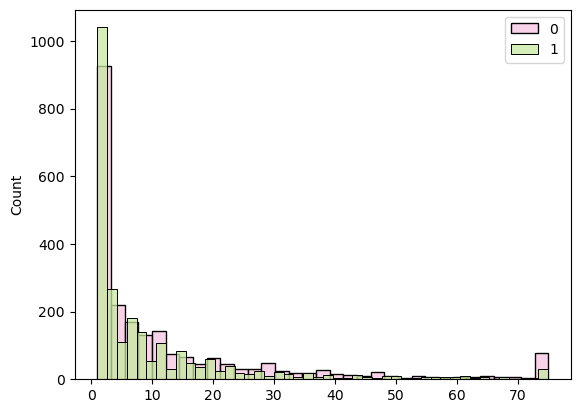

In [135]:
for i, trax in enumerate([downscale_tracks, tracks]):
    sns.histplot([len(track) for track in trax], color = sns.color_palette('PiYG', 2)[i], label = i )
    plt.legend()

In [138]:
tracks = track_and_show(downscale_obj, 
               downscale_seg, 
#                '/home/dayn/analysis/btrack/models/simplecase_cell_config.json', 
               '/home/dayn/analysis/btrack/models/particle_config.json', 
               20, 
               ["MOTION",
#                 "VISUAL"
               ],
               True
              )

[INFO][2023/04/14 01:47:15 pm] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
14-Apr-23 13:47:15 - btrack.libwrapper - INFO     - Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[WARNING][2023/04/14 01:47:15 pm] btrack (v0.5.0) shared library mismatch.
14-Apr-23 13:47:15 - btrack.core - WARNING  - btrack (v0.5.0) shared library mismatch.
[INFO][2023/04/14 01:47:15 pm] Starting BayesianTracker session
14-Apr-23 13:47:15 - btrack.core - INFO     - Starting BayesianTracker session
[INFO][2023/04/14 01:47:15 pm] Loading configuration file: /home/dayn/analysis/btrack/models/particle_config.json
14-Apr-23 13:47:15 - btrack.config - INFO     - Loading configuration file: /home/dayn/analysis/btrack/models/particle_config.json
[INFO][2023/04/14 01:47:15 pm] Objects are of type: <class 'list'>
14-Apr-23 13:47:15 - btrack.dataio - INFO     - Objects are of type: <class 'list'>
[INFO][2023/04

GLPK Integer Optimizer 5.0
12500 rows, 10763 columns, 15276 non-zeros
10763 integer variables, all of which are binary
Preprocessing...
6250 rows, 10763 columns, 15276 non-zeros
10763 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6250
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6250 rows, 10763 columns, 15276 non-zeros
*     0: obj =   3.345847643e+04 inf =   0.000e+00 (2684)
Perturbing LP to avoid stalling [1293]...
Removing LP perturbation [2695]...
*  2695: obj =   1.673872582e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  2695: mip =     not found yet >=              -inf        (1; 0)
+  2695: >>>>>   1.673872582e+04 >=   1.673872582e+04   0.0% (1; 0)
+  2695: mip =   1.673872582e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2023/04/14 01:47:25 pm] Ending BayesianTracker session
14-Apr-23 13:47:25 - btrack.core - INFO     - Ending BayesianTracker session


### This plot shows the visual features might confuse things if you get the search radius right...
butttt this shouldnt really be taken as definitive proof that the tracking performance has improved... the track length may increase on average but the veracity of the longer tracks may not be there

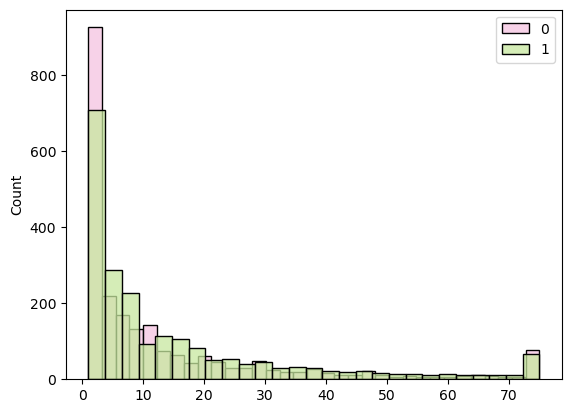

In [137]:
for i, trax in enumerate([downscale_tracks, tracks]):
    sns.histplot([len(track) for track in trax], color = sns.color_palette('PiYG', 2)[i], label = i )
    plt.legend()

In [151]:
tracks = track_and_show(downscale_obj, 
               downscale_seg, 
#                '/home/dayn/analysis/btrack/models/simplecase_cell_config.json', 
               '/home/dayn/analysis/btrack/models/particle_config.json', 
               15, 
               ["MOTION",
#                 "VISUAL"
               ],
               True
              )

[INFO][2023/04/14 02:24:49 pm] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
14-Apr-23 14:24:49 - btrack.libwrapper - INFO     - Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[WARNING][2023/04/14 02:24:49 pm] btrack (v0.5.0) shared library mismatch.
14-Apr-23 14:24:49 - btrack.core - WARNING  - btrack (v0.5.0) shared library mismatch.
[INFO][2023/04/14 02:24:49 pm] Starting BayesianTracker session
14-Apr-23 14:24:49 - btrack.core - INFO     - Starting BayesianTracker session
[INFO][2023/04/14 02:24:49 pm] Loading configuration file: /home/dayn/analysis/btrack/models/particle_config.json
14-Apr-23 14:24:49 - btrack.config - INFO     - Loading configuration file: /home/dayn/analysis/btrack/models/particle_config.json
[INFO][2023/04/14 02:24:49 pm] Objects are of type: <class 'list'>
14-Apr-23 14:24:49 - btrack.dataio - INFO     - Objects are of type: <class 'list'>
[INFO][2023/04

GLPK Integer Optimizer 5.0
12640 rows, 10833 columns, 15346 non-zeros
10833 integer variables, all of which are binary
Preprocessing...
6320 rows, 10833 columns, 15346 non-zeros
10833 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 6320
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
6320 rows, 10833 columns, 15346 non-zeros
*     0: obj =   3.419594492e+04 inf =   0.000e+00 (2778)
Perturbing LP to avoid stalling [1348]...
Removing LP perturbation [2796]...
*  2796: obj =   1.682239090e+04 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  2796: mip =     not found yet >=              -inf        (1; 0)
+  2796: >>>>>   1.682239090e+04 >=   1.682239090e+04   0.0% (1; 0)
+  2796: mip =   1.682239090e+04 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMA

[INFO][2023/04/14 02:24:58 pm] Ending BayesianTracker session
14-Apr-23 14:24:58 - btrack.core - INFO     - Ending BayesianTracker session


In [ ]:
for i, trax in enumerate([downscale_tracks, tracks]):
    sns.histplot([len(track) for track in trax], color = sns.color_palette('PiYG', 2)[i], label = i )
    plt.legend()